### Importing packages

In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.feature_selection import SelectKBest, chi2
from keras import Sequential
from keras.layers import Dense, Dropout, Input
from xgboost import XGBClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
print('Libraries Imported')

Libraries Imported


### Exploratory Data Analysis

In [167]:
delivery_data = pd.read_csv("parcel_delivery_dataset.csv")

y_col = 'delivery_time_window'

delivery_data.head()


delivery_data.hour = delivery_data.hour.replace([6,7,8,9,10,11], 'morning')
delivery_data.hour = delivery_data.hour.replace([12, 13, 14 ,15, 16, 17], 'afternoon')
delivery_data.hour = delivery_data.hour.replace([18, 19, 20, 21, 22, 23], 'evening')

In [168]:
delivery_data.dtypes

parcel_id                 int64
shipment_date            object
is_weekend                int64
hour                     object
distance_km             float64
parcel_size              object
parcel_weight_kg        float64
traffic_level            object
weather_condition        object
delivery_time_window     object
dtype: object

In [169]:
duplicate_rows = delivery_data[delivery_data.duplicated()]

print(f"There are {duplicate_rows.shape[0]} duplicate rows.")

There are 0 duplicate rows.


In [170]:
rows_with_nulls = delivery_data.isnull().sum()
print(rows_with_nulls)

parcel_id               0
shipment_date           0
is_weekend              0
hour                    0
distance_km             0
parcel_size             0
parcel_weight_kg        0
traffic_level           0
weather_condition       0
delivery_time_window    0
dtype: int64


So there are no duplicate rows in the dataset and no rows containing any NaN or Null values.

In [171]:
delivery_data.nunique()

parcel_id               50000
shipment_date             366
is_weekend                  2
hour                        3
distance_km             50000
parcel_size                 3
parcel_weight_kg        50000
traffic_level               3
weather_condition           4
delivery_time_window        3
dtype: int64

There are exactly the amount of values for the object dtype columns as you would expect (3, 3, 4 and 3), meaning there are no misspellings of categories. 

In [172]:
delivery_data = delivery_data.drop(['parcel_id'], axis = 1)

delivery_data.describe().T

,count,mean,std,min,25%,50%,75%,max
is_weekend,50000.0,0.284080,0.450980,0.000000,0.000000,0.000000,1.000000,1.000000
distance_km,50000.0,50.387477,28.552232,1.000548,25.642078,50.390299,75.081838,99.997243
parcel_weight_kg,50000.0,25.210404,14.273970,0.500780,12.798958,25.230957,37.450028,49.996822


In [173]:
#pairplot maken met ordinal scale en correlatie toevoegen werkt niet want allemaal categorisch
# traffic level naar numeriek

Remove parcel_id, as I assume it has no predictive power for the delivery window.

In [174]:
cat_cols=delivery_data.select_dtypes(include=['object']).columns
num_cols = delivery_data.select_dtypes(include=np.number).columns.tolist()

is_weekend
Skew : 0.96


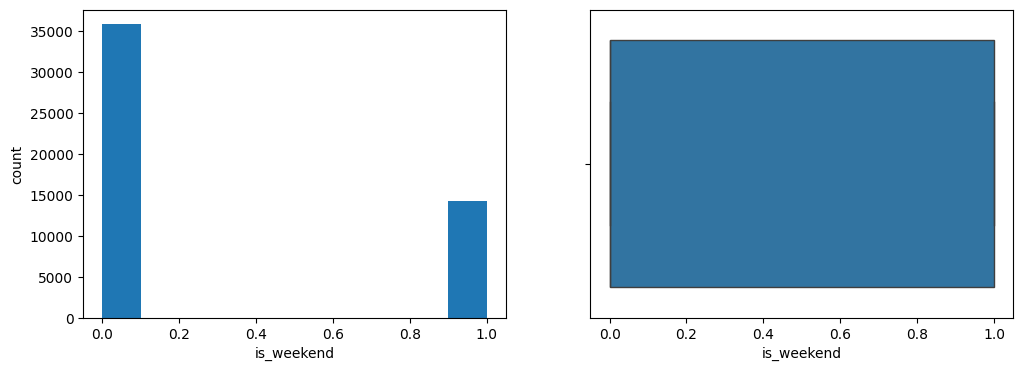

distance_km
Skew : 0.01


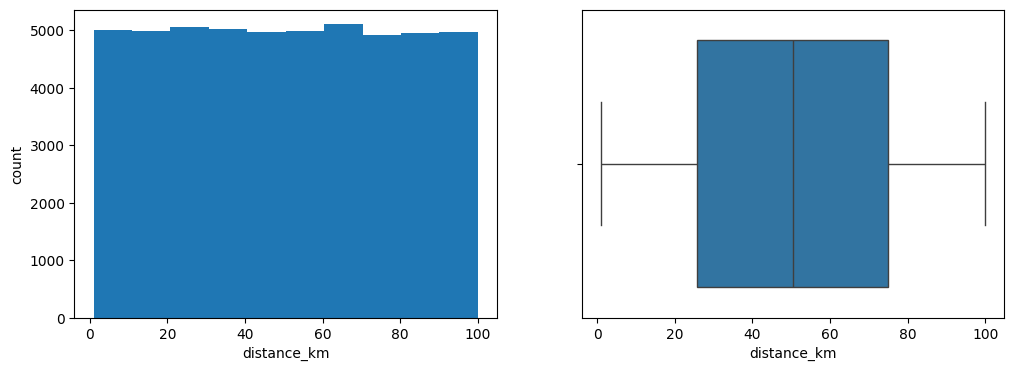

parcel_weight_kg
Skew : -0.0


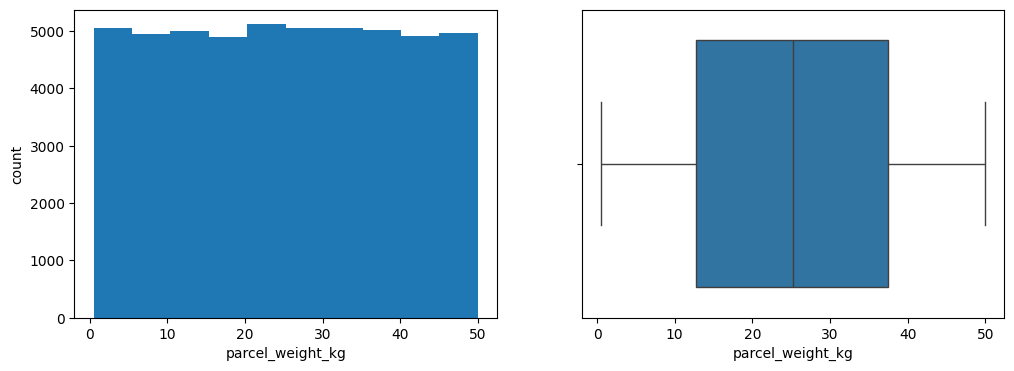

In [175]:
for col in num_cols:
    print(col)
    print('Skew :', round(delivery_data[col].skew(), 2))
    plt.figure(figsize = (12, 4))
    plt.subplot(1, 2, 1)
    delivery_data[col].hist(grid=False)
    plt.ylabel('count')
    plt.xlabel(col)
    plt.subplot(1, 2, 2)
    sns.boxplot(x=delivery_data[col])
    plt.show()

As is evident from the plots, there is about an equal amount of examples for the distance_km and parcel_weight values. is_weekend is skewed to the 0 (week days), which makes sense as there are both more weekdays and more packages get send during the week. The expected delivery hour peaks at ~9, 15 and 19/20, with few packages being delivered after 18. 9 and 15 are the mean hours from the delivery windows, so it makes sense that those are the most prevalent times. Fewer packages get delivered in the evening.

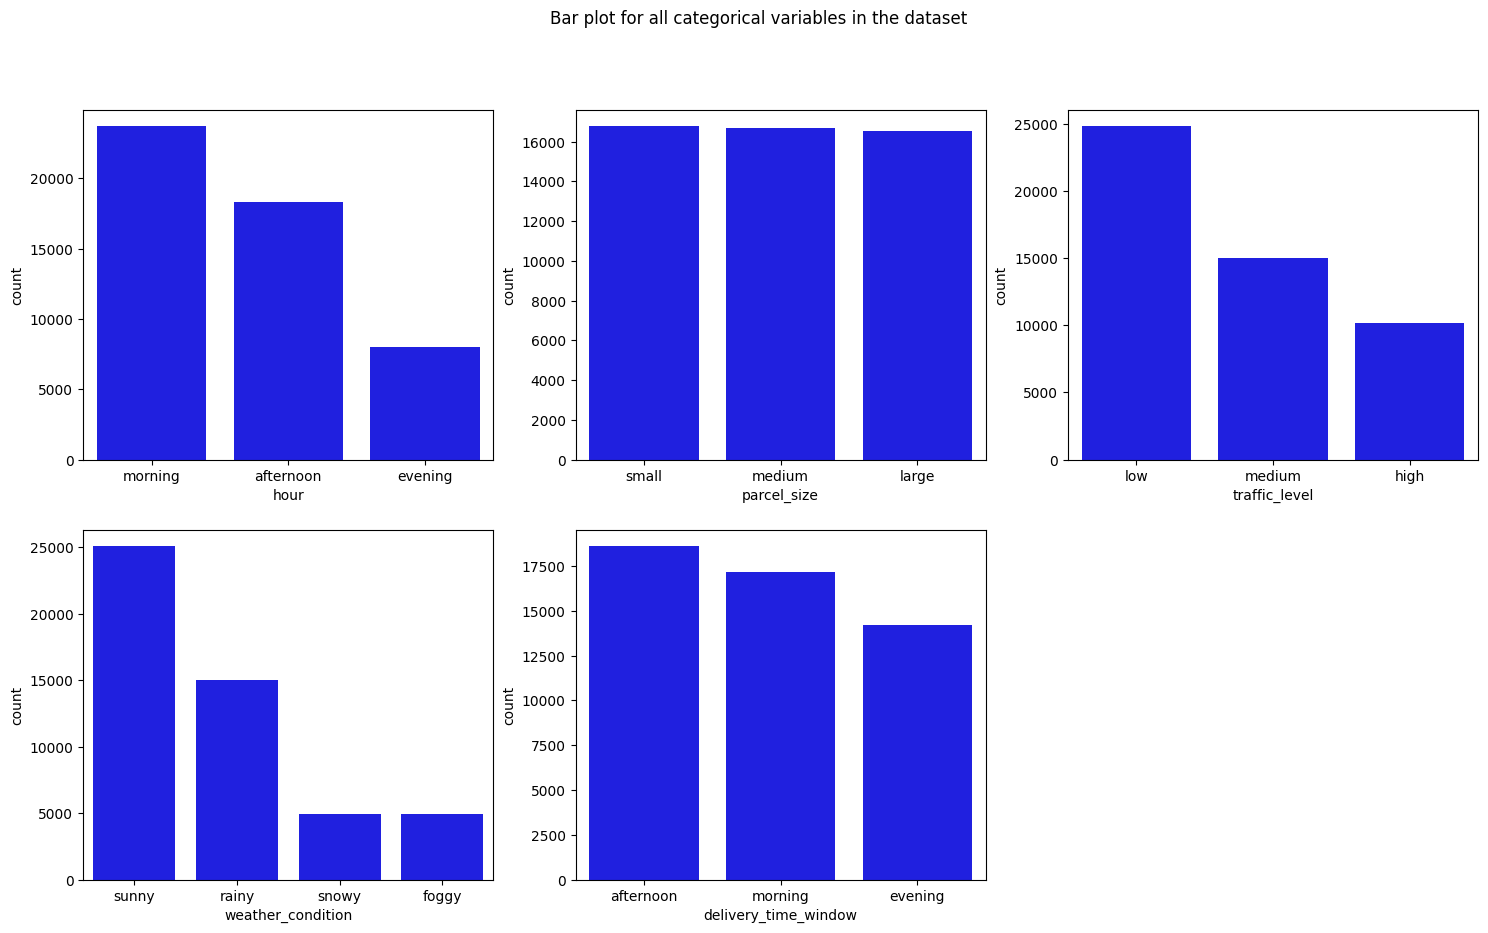

In [176]:
fig, axes = plt.subplots(2, 3, figsize = (18, 10))
axes[1][2].set_visible(False)
fig.suptitle('Bar plot for all categorical variables in the dataset')
for ax, col in zip(axes.ravel(), cat_cols[1:]):
    sns.countplot(ax = ax, x = col, data = delivery_data, color = 'blue', order = delivery_data[col].value_counts().index)
    ax.set_xlabel(col)



<Axes: xlabel='hour', ylabel='proportion'>

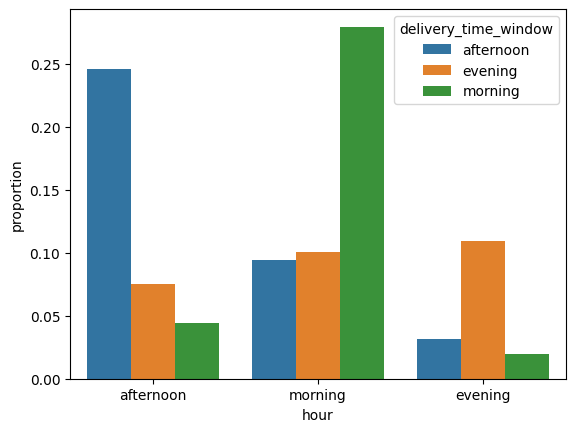

In [177]:
sns.countplot(x="hour", hue="delivery_time_window", data=delivery_data, stat = "proportion")

### Feature engineering and feature selection

In [178]:
def get_season(date):
  m = date.month
  x = m%12 // 3 + 1
  if x == 1:
    season = "Winter"
  if x == 2:
    season = "Spring"
  if x == 3:
    season = "Summer"
  if x == 4:
    season = "Autumn"
  return season

delivery_data.insert(len(delivery_data.columns)-1, 'season', pd.to_datetime(delivery_data['shipment_date'], format = '%Y-%m-%d'))

delivery_data['season'] = delivery_data['season'].apply(get_season)

delivery_data = delivery_data.drop(['shipment_date'], axis = 1)


Create a new column called 'season' from the shipment_date column. Season could be a good feature to predict the delivery_time_window.

In [179]:
def get_features(data, nr_features : int = 5):


    #Initialize the classifier and the encoder, as it cannot handle categorical data
    fs = SelectKBest(score_func=chi2, k=5)

    encoder = OrdinalEncoder()

    #Selecting columns used to make a selection later
    cat_cols=data.select_dtypes(include=['object']).columns

    X_cols = data.iloc[:, :-1].columns
    
    encoder.fit(data[cat_cols])

    #Create copy of data to encode and train the classifier with

    place_holder = data.copy(deep = True)

    #Encode the categorical columns of the copy and split into X and y training and test sets
    place_holder[cat_cols] = encoder.transform(place_holder[cat_cols])

    X = place_holder.iloc[:, :-1].values

    y = place_holder.iloc[:, -1].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 21)

    #Train the classifier
    fs.fit(X_train, y_train)

    #Create mask for most important features and add them to a list
    mask = fs.get_support()
    new_features = []

    for bool_val, feature in zip(mask, X_cols):
        if bool_val:
            new_features.append(feature)

    new_features.append(y_col)

    return data[new_features]

delivery_data_fs = get_features(delivery_data)

So the important features seem to be is_weekend, hour, distance_km, traffic_level and weather_condition.

### Encoding the data

In [ ]:
def one_hot_encode__data(data):
    """This function encodes categorical data by use of one-hot encoding, so it can be used by the sklearn models.

    Args:
        data (dataframe): All the data that will be used for training and evaluation, both numerical and categorical

    Returns:
        Array : The function returns all the numerical data, with the categorical data one-hot encoded.
    """       
    #Get the categorical columns and data

    cat_cols=data.select_dtypes(include=['object']).columns
    # data_cat = data[cat_cols]
    test = data.copy(deep = True)
    #Get the X and y data
    
    # X = data_cat.iloc[:, :-1]
    # cat_col_X = X.select_dtypes(include=['object']).columns

    # y = data_cat.iloc[:, -1]

    #Define the encoders

    one_hot = OneHotEncoder(sparse_output=False)

    label_bin = LabelBinarizer(sparse_output=False)

    #Fit the encoders and transform the data in one-hot format.

    hoi = data[cat_cols]

    oh_enc = one_hot.fit_transform(data[cat_cols])

    # data = pd.DataFrame(hoi2, columns = one_hot.get_feature_names_out(cat_cols))
    
    num_data = data.loc[:, ~data.columns.isin(cat_cols)].values
    
    all_data = np.concatenate((num_data, oh_enc), axis = 1)
    
    #Encode all the categorical features and split in X and y arrays

    # data[cat_cols] = one_hot.transform(data[cat_cols])

    y = all_data[:, -3:]
    
    X = all_data[:, :-3]
    
    return X, y

def ordinal_encode_data(data):
    """This function encodes categorical data by use of ordinal encoding, so it can be used by the sklearn models.

    Args:
        data (dataframe): All the data that will be used for training and evaluation, both numerical and categorical

    Returns:
        Array : The function returns all the numerical data, with the categorical data ordinal encoded.
    """   

    #Get the categorical columns and data

    cat_cols=data.select_dtypes(include=['object']).columns
    data_cat = data[cat_cols]

    #Define the encoders

    ord_enc = OrdinalEncoder()

    #Fit the encoders and transform the data in one-hot format.

    ord_enc.fit_transform(data[cat_cols])

    #Encode all the categorical features and split in X and y arrays

    data[cat_cols] = ord_enc.transform(data[cat_cols])

    y = delivery_data_fs.iloc[:, -1].values

    X = delivery_data_fs.iloc[:, :-1].values

    return X, y

X_oh, y_oh = one_hot_encode__data(delivery_data_fs)

X_ord, y_ord = ordinal_encode_data(delivery_data_fs)

### Creating the neural network and Random Forest

In [243]:
# Create the neural network
def get_model(n_inputs : int, n_outputs : int, optimizer : str = 'adam', activation : str = 'relu', dropout : float = 0.5):
   """This function generates a neural network using the keras library.

   Args:
       n_inputs (int): The number of input features.
       n_outputs (int): The number of output features.
       optimizer (str, optional): The optimizer used by the compiler. Defaults to 'adam'.
       activation (str, optional): The activation function used by the layers in the neural network. Defaults to 'relu'.
       dropout (float, optional): The dropout probability of the dropout layer. Defaults to 0.5.

   Returns:
       model: Returns a neural network model with 5 layers, of which two dropout and two hidden layer. 
   """   
   model = Sequential()
   model.add(Input(shape=(n_inputs,)))
   model.add(Dense(n_inputs, kernel_initializer='he_uniform', activation = activation))
   model.add(Dropout(dropout))
   model.add(Dense(32, activation = activation))
   model.add(Dropout(dropout))
   model.add(Dense(n_outputs, activation='sigmoid'))

   #compile the model
   model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = ['accuracy'])
   return model
 
# evaluate a model using repeated k-fold cross-validation
def evaluate_ANN_model(X, y, optimizer : str = 'adam', activation : str = 'relu', dropout : float = 0.1):
    """This function evaluates a model, using kfold cross-validation and returns the accuracy of the predictions.

    Args:
        X (numpy array): The feature data with which y is predicted, with the categorical variables in one-hot encoded format. 
        y (numpy array): The target variable that is to be predicted, in one-hot encoded format.
        optimizer (str, optional): Optimizer used for the neural network. Defaults to 'adam'.
        activation (str, optional): Activation function used for the network layers. Defaults to 'relu'.
        dropout (float, optional): Dropout probability of nodes in the network. Defaults to 0.5.

    Returns:
        List of accuracy and auc scores: The function returns a list of all accuracy scores obtained from the model training.
    """ 
    results = list()
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    # define evaluation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state = 1)
    # enumerate folds
    for train_ix, test_ix in cv.split(X):
        # prepare data
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        # define model
        model = get_model(n_inputs, n_outputs, optimizer, activation, dropout)
        # fit model, using a validation split
        model.fit(X_train, y_train, verbose=0, batch_size = 64, epochs=100, validation_split = 0.11)
        # make a prediction on the test set
        yhat = model.predict(X_test)
        # round probabilities to class labels
        max = yhat.max(axis=1).reshape(-1, 1)

        res = np.where(yhat == max, 1, 0)
        # calculate accuracy and auc
        acc = accuracy_score(y_test, res)

        auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')

        # store result
        print('>%.3f' % acc + '>%.3f' % auc)
        results.append([acc, auc])
    return results

In [ ]:
#kFold cross validation function with model training for other models.
def kFold(X, y, model):
    """This function trains and evaluates a model using kFold cross-validation.

    Args:
        X (Array): _description_
        y (Array): _description_
        model (SKLearn model): _description_

    Returns:
        List: The function returns a list of all the accuracies and auc-scores from the kFold cross-validation.
    """    
    results = list()
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state = 1)
    # enumerate folds
    for train_ix, test_ix in cv.split(X):
        # prepare data
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        # define model
        model = model
        # fit model, using a validation split
        model.fit(X_train, y_train)
        # make a prediction on the test set
        yhat = model.predict(X_test)
        # compute evaluation metrics
        acc = accuracy_score(y_test, yhat)

        auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')

        results.append([acc, auc])
    return results

### Hyperparameter tuning for Neural Network and Random Forest

In [ ]:
X_train, X_test,  y_train, y_test = train_test_split(X_oh, y_oh, test_size = 0.2, random_state = 1)

model = KerasClassifier(model=get_model, 
                        optimizer = 'adam', 
                        activation = 'relu', 
                        verbose=0,
                        n_inputs = 18,
                        n_outputs = 3, 
                        epochs=10, 
                        batch_size=32, 
                        dropout = 0.5)

# Define the hyperparameters to tune
param_grid = {
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'activation': ['relu', 'tanh'],
    'batch_size': [64, 128, 256],
    'epochs': [50, 80, 100],
    'dropout': [0.2, 0,3, 0.4, 0.5]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, error_score='raise')
grid_result = grid.fit(X, y)

print(f"Best Parameters: {grid_result.best_params_}")
print(f"Best Accuracy: {grid_result.best_score_}")

Best Parameters: {'activation': 'tanh', 'batch_size': 256, 'dropout': 0.1, 'epochs': 100, 'optimizer': 'adam'}
Best Accuracy: 0.6318800145057941


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_ord, y_ord, test_size = 0.2, random_state = 21)

grid = {'n_estimators': [10, 50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]}

rf = RandomForestClassifier()

grid = GridSearchCV(estimator=rf, param_grid=grid, cv=3, n_jobs=-1, verbose=0)

grid_result = grid.fit(X_train, y_train)

print(f"Best Parameters: {grid_result.best_params_}")
print(f"Best Accuracy: {grid_result.best_score_}")

Best Parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best Accuracy: 0.6313250864119961


### Model training and evaluation

In [244]:
# evaluate model
results = evaluate_ANN_model(X_oh, y_oh, 'adam', 'tanh', 0.3)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step


ValueError: Classification metrics can't handle a mix of multiclass-multioutput and multilabel-indicator targets

In [101]:
rf = RandomForestClassifier(**grid_result.best_params_)

result = kFold(rf)


In [100]:
grid_result.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 200}

In [54]:
model = XGBClassifier(objective='multi:softprob', reg_lambda = 100, reg_alpha = 100)
result = kFold(X, y, model)



0.6288 0.7457924609342915
0.6324 0.7378409899408869
0.6336 0.7398892574243782
0.6478 0.75250016512426
0.6432 0.7501410769465916
0.626 0.7382992146477431
0.6316 0.7488256215298089
0.6302 0.7379770010497024
0.6298 0.745863652026619
0.6382 0.7465132688099819
0.6378 0.7493340943957422
0.6322 0.7473687877734606
0.6332 0.7455786775504896
0.6318 0.7416202054801042
0.619 0.7359248845312322
0.6484 0.7508589945219241
0.6364 0.7471204134684841
0.6322 0.7339008249449379
0.6354 0.7430791488705529
0.6352 0.7516670589740482
0.637 0.7487960520681011
0.6342 0.7446776640327416
0.6324 0.7462111229168258
0.633 0.7484889126483201
0.6316 0.7411143626681881
0.6368 0.7439733813008385
0.6436 0.7529939398349689
0.6344 0.742846519312122
0.6334 0.7464205485448101
0.6252 0.7302206336831881


In [56]:
print(np.mean(result, axis =0))

[0.63416    0.74452796]


In [447]:
# Calculate permutation feature importance
result = permutation_importance(
    model, X_test, y_test, scoring='neg_log_loss', n_repeats=10, random_state=42
)

# Get the feature importances and sort them in descending order
feature_importances = pd.Series(result.importances_mean, index=delivery_data.iloc[:, :-1].columns).sort_values(ascending=False)

# Print the feature importances
print(feature_importances)

hour                 0.242596
is_weekend           0.006652
traffic_level        0.003565
weather_condition    0.000649
parcel_weight_kg     0.000025
parcel_size          0.000019
distance_km          0.000014
dtype: float64


In [25]:
model = OneVsRestClassifier(LogisticRegression(solver='newton-cholesky', max_iter=1000, penalty='l2', C = 0.01))
scaler = StandardScaler()

X[:, [1, 2]] = scaler.fit_transform(X[:, [1, 2]])

result = kFold(X, y, model)

0.6198 0.6970101488687668
0.6254 0.6970942820688283
0.6258 0.6957739178834427
0.6412 0.7033575358860986
0.634 0.700642525727717
0.6216 0.6910473441526599
0.6202 0.7028875438207104
0.6254 0.6966386740755984
0.625 0.6967193889561405
0.6344 0.7047743364728914
0.6286 0.6984422581924576
0.6252 0.7024048571734012
0.6264 0.7050950441497855
0.6272 0.6974040292569056
0.6176 0.6869882361044531
0.6418 0.7009473355743904
0.6286 0.6986138106836073
0.6224 0.6943238386027503
0.6306 0.6990093147589915
0.6302 0.7030519364384861
0.6336 0.6961240114300818
0.6296 0.6943254977932304
0.6284 0.6965590466477285
0.629 0.6974767725316022
0.6254 0.6985598676270364
0.6296 0.7027530689594772
0.6362 0.7045593246722118
0.6264 0.7008981649438922
0.6274 0.7018587607897189
0.615 0.6937285328642643
